# Model Training and Deployment
In this notebook, we demonstrate how to access multimodal features, including genomics features, clinical features, and radiomics features, from SageMaker Feature Store. We train a XGBoost model to predict the survival status of patients diagnosed with non-small cell lung cancer. In the end we host the trained model for inference on the testing dataset.

## Step 1: Read in the SageMaker JumpStart Solution configuration

In [ ]:
import json

SOLUTION_CONFIG = json.load(open("stack_outputs.json"))
SOLUTION_BUCKET = SOLUTION_CONFIG["SolutionS3Bucket"]
REGION = SOLUTION_CONFIG["AWSRegion"]
SOLUTION_PREFIX = SOLUTION_CONFIG["SolutionPrefix"]
SOLUTION_NAME = SOLUTION_CONFIG["SolutionName"]
BUCKET = SOLUTION_CONFIG["S3Bucket"]
ECR_REPOSITORY = SOLUTION_CONFIG["SageMakerProcessingJobContainerName"]
CONTAINER_BUILD_PROJECT = SOLUTION_CONFIG["SageMakerProcessingJobContainerBuild"]
ACCOUNT_ID = SOLUTION_CONFIG["AccountID"]

## Step 2: Setting up access to the multi-modal feature store

Next, we will get the feature groups created by the processing notebooks. 

In [ ]:
import boto3
import sagemaker
from sagemaker.session import Session


boto_session = boto3.Session(region_name=REGION)
sagemaker_client = boto_session.client(service_name="sagemaker", region_name=REGION)
featurestore_runtime = boto_session.client(service_name="sagemaker-featurestore-runtime", region_name=REGION)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

In [ ]:
from sagemaker.feature_store.feature_group import FeatureGroup

%store -r genomic_feature_group_name
%store -r clinical_feature_group_name
%store -r imaging_feature_group_name

genomic_feature_group = FeatureGroup(name=genomic_feature_group_name, sagemaker_session=feature_store_session)
clinical_feature_group = FeatureGroup(name=clinical_feature_group_name, sagemaker_session=feature_store_session)
imaging_feature_group = FeatureGroup(name=imaging_feature_group_name, sagemaker_session=feature_store_session)

prefix = 'multi-model-health-ml'
fs_output_location = f's3://{BUCKET}/{prefix}/feature-store-queries'

In [ ]:
genomic_query = genomic_feature_group.athena_query()
clinical_query = clinical_feature_group.athena_query()
imaging_query = imaging_feature_group.athena_query()

genomic_table = genomic_query.table_name
clinical_table = clinical_query.table_name
imaging_table = imaging_query.table_name

print('Table names:')
print(genomic_table)
print(clinical_table)
print(imaging_table)

Because medical imaging processings take some time to complete for all patients and because it takes 5-10 minutes for the the feature store to synchronize the offline store, imaging features may not be available in the offline store for us to create a complete trainnig dataset. To make sure the medical imaging features are available for training, let's check the total entry count and wait before proceeding.

In [ ]:
import time

query_string = f'SELECT COUNT(subject) FROM "{imaging_table}"'
imaging_data_count = 0
total_imaging_entries = 123
total_waiting_time = 600
current_waiting_time = 0

while imaging_data_count < total_imaging_entries and current_waiting_time < total_waiting_time:
    imaging_query.run(query_string=query_string, output_location=fs_output_location)
    imaging_query.wait()
    imaging_data_count = imaging_query.as_dataframe().values[0][0]
    print(f'Total feature count in imaging offline store: {imaging_data_count}')
    if imaging_data_count < total_imaging_entries:
        print(f'We expect {total_imaging_entries} entries in the offline store. Wait 15 seconds.')
        time.sleep(15)
        current_waiting_time += 15
    else:
        print('We have all the imaging features. Please proceed.')

## Step 3: Query against multi-modal feature store to create training dataset

Next step, we will create a ML dataset by querying the multimodal feature groups and joining them. You can choose to query features from 3 pre-determined combinations with the `data_type` argument in the `get_features()` function: 
1. genomic features only
2. genomic + clinical features
3. genomic + clinical + imaging features


In [ ]:
supported_data_type = ('genomic', 'genomic-clinical', 'genomic-clinical-imaging')

def get_features(data_type, output_location):  
    if (data_type == 'genomic'):
        query_string = f'SELECT * FROM "{genomic_table}"'
        print(query_string)
        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
 
        # Drop features
        drop_features = ['case_id', 'eventtime', 'write_time', 'api_invocation_time', 'is_deleted'] 
        dataset = dataset.drop(drop_features, axis = 1) 
        
    elif (data_type == 'genomic-clinical'):
        query_string = f'''SELECT * FROM "{clinical_table}"
                           LEFT JOIN "{genomic_table}" ON "{clinical_table}".case_id = "{genomic_table}".case_id'''
        print(query_string)

        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
        
        # Drop features
        drop_features = ['case_id', 'case_id.1', 
                  'eventtime', 'write_time', 'api_invocation_time', 'is_deleted',
                  'eventtime.1', 'write_time.1', 'api_invocation_time.1', 'is_deleted.1']
        dataset = dataset.drop(drop_features, axis = 1)
        
    elif (data_type == 'genomic-clinical-imaging'):
        query_string = f'''SELECT "{genomic_table}".*, "{clinical_table}".*, "{imaging_table}".* 
                           FROM "{genomic_table}"
                               LEFT OUTER JOIN "{clinical_table}" ON "{clinical_table}".case_id = "{genomic_table}".case_id
                               LEFT OUTER JOIN "{imaging_table}" ON "{clinical_table}".case_id = "{imaging_table}".subject
                           ORDER BY "{clinical_table}".case_id ASC'''
        print(query_string)
        
        genomic_query.run(query_string=query_string, output_location=output_location)
        genomic_query.wait()
        dataset = genomic_query.as_dataframe()
        
        # Drop features
        drop_features = ['case_id', 'case_id.1', 
                  'eventtime', 'write_time', 'api_invocation_time', 'is_deleted',
                  'eventtime.1', 'write_time.1', 'api_invocation_time.1', 'is_deleted.1', 
                  'eventtime.2', 'write_time.2', 'api_invocation_time.2', 'is_deleted.2']
        drop_features_img = ['imagename', 'maskname', 'scandate', 'subject']
        drop_features_img += [i for i in dataset.columns.tolist() if 'diagnostics' in i]
        
        dataset = dataset.drop(drop_features + drop_features_img, axis = 1)
        
        
    elif data_type not in supported_data_type:
        raise KeyError(f'data_type {data_type} is not supported for this analysis.')
        
    return dataset

In this notebook, we will generate a dataset by combining the features from gemonic, clinical and imaging tables.

In [ ]:
data_type = 'genomic-clinical-imaging'

dataset = get_features(data_type, fs_output_location)

The query result from athena will be stored in S3 bucket, so that in the following steps, we can use it from the S3 bucket.

In [ ]:
# Write to csv in S3 without headers and index column.
filename=f'{data_type}-dataset.csv'
dataset_uri_prefix = f's3://{BUCKET}/{prefix}/training_input/'

dataset.to_csv(filename, header=False, index=False)
s3_client = boto3.client('s3', region_name=REGION)
s3_client.upload_file(filename, BUCKET, f'{prefix}/training_input/{filename}')

In [ ]:
# X for features, y for target
X = dataset.drop(['survivalstatus'], axis=1)
y = dataset['survivalstatus']

# replacing NaNs with zeros
X.fillna(value=0., inplace=True)

print ('Number of samples in multimodal data: ', dataset.shape[0])
print ('Number of features in multimodal data: ', dataset.shape[1])

## Step 4: Data Preprocessing
We randomly shuffle the full dataset and divide it into 80% for training and 20% for testing the model. Later we further split the training data into 80% for training and 20% for validating the model.
We perform feature scaling to normalize the range of independent features. This is for performing principal component analysis (PCA) on the features to identify the most discriminative features, even though XGBoost algorithm does not require feature normalization.
With PCA, we identify the top principal components that contribute to 95% variance in the data and reduce the feature dimensionality to a smaller number of principal components. Then we furhter analyze the importance of each data domain for the given predictive task by generating feature importance heat maps and correlation circles. We will explain in more detail in corresponding cell.

In [ ]:
from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Scale features with `StandardScaler` from `sklearn`.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Add Feature Scaling
sc = StandardScaler()
sc.fit(X_trainval)
X_trainval_scaled = sc.transform(X_trainval)
X_test_scaled = sc.transform(X_test)

### Run PCA for Dimensioanality Reduction

In [ ]:
from sklearn.decomposition import PCA

# Set variance threshold for PCA
pca_threshold = 0.95
pca = PCA(n_components=pca_threshold, random_state=0)
X_trainval_pca = pca.fit_transform(X_trainval_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,10)})

F = np.cumsum(pca.explained_variance_ratio_)

plt.figure()
plt.plot(F)
plt.xlabel('Number of PCs')
plt.ylabel('Explanation of Variance Ratio')
print('Number of principal components selected: ', len(pca.explained_variance_ratio_))

### Get Feature Importance
To determine the importance the features belonging to different modalities, we explore the composition of the principal components from the multimodal features. These principal components are linear combinations of the original features taken from each modality. They constitute a set of linearly uncorrelated features that describe the variance in the data. The first principal component explains the most variance, followed by subsequent principal components each explaining successively less of the variance in the data.

We plot the feature importance (level of variance in principal components) as a heat map. The heat map demonstrates the variance explained by each principal compnent, color-coded by data modality, for the top 20 principal components. The X-axis denotes principal components, Y-axis denotes features obtained from different domains (genomic, clinical, and medical imaging), and cell intensity denotes that feature’s level of variance (normalized value) for the corresponding principal component.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Get column header for visualization
header = dataset.columns.values

names = list(header)
names = names[1:]

# PCA and feature importance
# Indices depend on the above join operation on multiple tables  
indices = {'imaging': 108, 'clinical': 21}

features_projected = abs(pca.components_).T
fn = MinMaxScaler().fit_transform(features_projected*pca.explained_variance_ratio_)

# Select top 20 PCs to plot
n_pc = 20
fn = fn[:,:n_pc]

fn_genomic = fn[0:indices['clinical'], :]
fn_clinical = fn[indices['clinical']:indices['imaging'], :]
fn_imaging = fn[indices['imaging']:, :]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, gridspec_kw={'wspace':0.025, 'hspace':0.052, 'height_ratios': [indices['clinical'], indices['imaging']-indices['clinical']+1, X.shape[1]-indices['imaging']]})

sns.heatmap(fn_genomic, ax=ax1, xticklabels=False, yticklabels=False, cmap="Blues", cbar=True)
sns.heatmap(fn_clinical, ax=ax2, xticklabels=False, yticklabels=False, cmap="Reds", cbar=True)
sns.heatmap(fn_imaging, ax=ax3, yticklabels=False, cmap="Greens", cbar=True)
ax3.set_xlabel('Principal Components')
ax3.set_ylabel('Medical Imaging')
ax2.set_ylabel('Clinical')
ax1.set_ylabel('Genomic')
plt.subplots_adjust(wspace=None, hspace=None)
plt.savefig('pca_matrix.png', dpi=450, bbox_inches='tight')

 We can observe the following in the heat map. For the first few components, medical imaging features are most heavily weighted and have higher variance (higher intensity in heat map) than clinical and genomic features, indicating the importance of medical imaging features for survival outcome prediction. However, from the third principal component on, we see the weighting of the clinical and genomic modality. This shows how the clinical and genomic modalities explain additional variance beyond what is captured in the medical images.

### Plot Correlation Circle
We also plot a variable correlation circle to understand how each original feature correlates to the principal components. 

In [ ]:
fig = plt.figure()
# Principal components to plot
pc_n1 = 4
pc_n2 = 5
r = np.linalg.norm(fn[:,pc_n1:pc_n2], axis=1)

ix_r = np.argsort(-r)
# Select top 30 features
top_r = 30
for i in range(top_r):
    plt.plot([0, fn[ix_r[i],0]], [0, fn[ix_r[i],1]], lw=3., label=names[ix_r[i]])

temp = np.max(r)
ax = fig.add_subplot(1, 1, 1)
circ = plt.Circle((0, 0), radius=temp, edgecolor=None, facecolor='w')
ax.add_patch(circ)

plt.xlim([-temp, temp])
plt.ylim([-temp, temp])
plt.legend()
plt.show()
plt.savefig('correlationcircle.png', dpi=300, bbox_inches='tight')

The variable correlation circle depicts correlation between top 25 features or variables of the fourth and fifth principal components. The angle between a pair of vectors indicates the level of correlation between them. A small angle indicates positive correlation, whereas an angle close to 180 degrees indicates negative correlation. The distance between the feature and the origin indicates how well the feature is represented in the plot. For these principal components, the top 25 features are obtained from all three domains: medical imaging (eg. original_glcm_clustershade), genomic (eg. gdf15), and clinical (eg. pack_years, histology_adinocarcinoma).

### Split Data for Training and Validation

In [ ]:
import pandas as pd

# Split into training and validation data
X_train_pca, X_val_pca, y_train, y_val = train_test_split(X_trainval_pca, y_trainval, test_size=0.2, random_state=0)

print('Number of training samples: %d'%len(y_train))
print('Number of validation samples: %d'%len(y_val))

# Create training, validation, and test data by adding label as the first column and removing headers
X_train_pca = pd.DataFrame.from_records(X_train_pca)
train_data = pd.concat([y_train.reset_index(drop=True), X_train_pca.reset_index(drop=True)], axis=1)

X_val_pca = pd.DataFrame.from_records(X_val_pca)
validation_data = pd.concat([y_val.reset_index(drop=True), X_val_pca.reset_index(drop=True)], axis=1)

X_test_pca = pd.DataFrame.from_records(X_test_pca)
test_data = pd.concat([y_test.reset_index(drop=True), X_test_pca.reset_index(drop=True)], axis=1)

## Step 5: Train the model
As we are predicting the survival status (death or alive) using the multimodal features, it is a binary classification problem. We use the SageMaker built-in XGBoost algorithm, which is highly optimized for AWS compute infrastructure, and SageMaker managed training feature to train a model to predict the survival status. We save the processed dataframes (`train_data`, `validation_data`, and `test_data`) as CSV files and upload to S3 bucket for model training. When using SageMaker managed training, one compute instance (`ml.m5.xlarge` in this solution) is provisioned to run the model training, instead of using compute resource on the notebook. Training and validation datasets in S3 bucket are automatically downloaded to the training instance. The compute instance will be shutdown once the training completes without any manual termination and management overhead.

We record the training job as a trial component to the same experiment and trial we created in [3_preprocessing_imaging_data](./3_preprocess_imaging_data.ipynb).ipynb to preserve the lineage. 

In [ ]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from botocore.exceptions import ClientError

experiment_name = f'{SOLUTION_PREFIX}-nsclc'
trial_name = f'{SOLUTION_PREFIX}-trial'

# create the experiment if it doesn't exist
try:
    experiment = Experiment.load(experiment_name=experiment_name)
except Exception as e:
    if "ResourceNotFound" in str(e):
        experiment = Experiment.create(
            experiment_name=experiment_name,
            sagemaker_boto_client=SM_BOTO,
            description='Lung cancer survival prediction using multi-modal Non Small Cell Lung Cancer (NSCLC) Radiogenomic dataset')
        print(f'{experiment_name} experiment is created!')


# create the trial if it doesn't exist
try:
    exp_trial = Trial.load(trial_name=trial_name)
except Exception as e:
    if "ResourceNotFound" in str(e):
        exp_trial = Trial.create(experiment_name=experiment_name, 
                                 sagemaker_boto_client=SM_BOTO,
                                 trial_name=trial_name)
        print(f'{exp_trial} trial is created!')

In [ ]:
import os
import sagemaker
from sagemaker.image_uris import retrieve
from sagemaker.session import TrainingInput

container = retrieve("xgboost", region=REGION, version='1.2-1')

xgb = sagemaker.estimator.Estimator(container,
                                    sagemaker.get_execution_role(), 
                                    instance_count=1, 
                                    instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/training-output'.format(BUCKET, prefix),
                                    base_job_name='sagemaker-soln-lcsp-js-training',
                                    sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(eta=0.1, objective='binary:logistic', num_round=10) 

# Save data
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(BUCKET).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

s3_input_train = TrainingInput(s3_data='s3://{}/{}/train/train.csv'.format(BUCKET, prefix), 
                               content_type='text/csv')
s3_input_validation = TrainingInput(s3_data='s3://{}/{}/validation/validation.csv'.format(BUCKET, prefix), 
                                    content_type='text/csv')

experiment_config={'ExperimentName': experiment_name,
                   'TrialName': trial_name,
                   'TrialComponentDisplayName': 'Training'}

# Train model
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation},
        experiment_config=experiment_config)

## Step 6: Deploy the Model

After we have trained a model, we can deploy the model to an Amazon SageMaker endpoint to give us the ability to make predictions in real-time. To deploy the endpoint, we will use the [Model's](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) `deploy()` method. The deploy method uses several parameters. We provide the deploy method with an `instance_count` which specifies the number of compute instances to launch initially and `instance_type` which specifies the compute instance type. We then provide a `CSVSerilizer` which is used to serialize incoming data for our endpoint. Then we need an `endpoint_name` which is the name of our endpoint and must be unique to your account. Once the endpoint has been deployed (this usually takes 5 minutes or so) a [Predictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) is returned. 

For further information on available [instance types](https://docs.aws.amazon.com/sagemaker/latest/dg/notebooks-available-instance-types.html), [types of endpoints](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html), and [serializers](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) availalbe please click on the corresponding links. 

In [ ]:
from sagemaker.serializers import CSVSerializer

endpoint_name = SOLUTION_PREFIX + "-endpoint"

xgb_predictor = xgb.deploy( initial_instance_count = 1, 
                            instance_type = 'ml.m5.xlarge', 
                            serializer = CSVSerializer(),
                            endpoint_name=endpoint_name)

## Step 7: Test the Model

Our model has been deployed to a SageMaker endpoint, now we can make requests and receive predictions in real-time. Now we can create a [Predictor](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html) object to make requests to the endpoint. To make predictions we will use the `predict()` method to pass in data from the test_data dataframe. The predictor will return a probability. If the probablity is greater than 0.5, the patient is less likely to survive Non-Small Cell Lung Cancer (NSCLC). If the probability is less than 0.5, the patient is more likely to survive NSCLC. 

In [42]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker.Session(), serializer=CSVSerializer())
predictions = predictor.predict(test_data.to_numpy()[:,1:]).decode('utf-8') 

# Predictions come back as str. Below transforms stings to float and the probability to int. 
y_predict = [1 if float(pred) > 0.5 else 0 for pred in predictions.split(',')]

In [43]:
# Print model metrics
acc = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict, average='weighted')
prec = precision_score(y_test, y_predict, average='weighted')
rec = recall_score(y_test, y_predict, average='weighted')

print('Accuracy: ', acc)
print('F1 score: ', f1)
print('Precision: ', prec)
print('Recall: ', rec)

Accuracy:  0.75
F1 score:  0.7555555555555555
Precision:  0.7714285714285714
Recall:  0.75


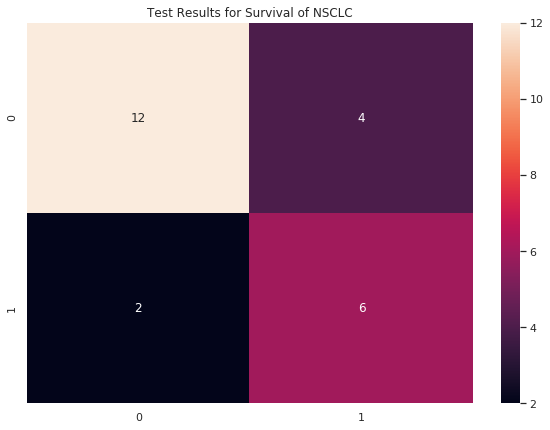

In [47]:
import sklearn.metrics as skm

# Print results in the form of a confusion matrix
cm = skm.confusion_matrix(y_test, y_predict)
plt.figure(figsize = (10,7))
plt.title('Test Results for Survival of NSCLC')
sns.heatmap(cm, annot=True)

## Step 8: Clean up

After you are done using this notebook, delete the model and the endpoint to avoid any incurring charges. Also we clean up the SageMaker experiment from the registry.

In [ ]:
xgb_predictor.delete_model()
xgb_predictor.delete_endpoint()

In [ ]:
%%time

experiment.delete_all(action="--force")